In [2]:
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

from mediapipe.tasks.python import vision
import mediapipe as mp
import cv2
import time

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


2023-06-08 08:40:50.310947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 08:40:50.507896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2023-06-08 08:40:50.507921: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-08 08:40:51.363897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open share

In [2]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Train the classifier

In [3]:
# !wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
# !unzip rps_data_sample.zip
dataset_path = "hands"


In [4]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)


hands
['stay', 'come', 'none', 'sit', 'hands_down', 'down']


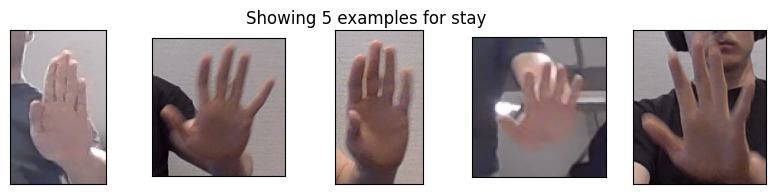

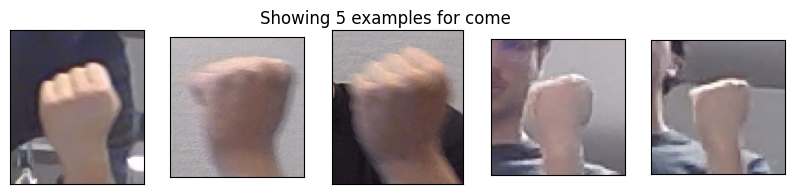

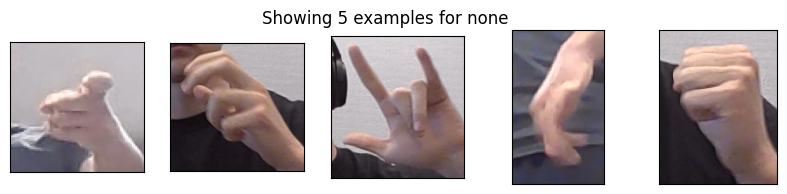

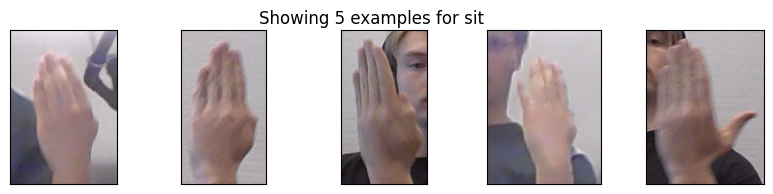

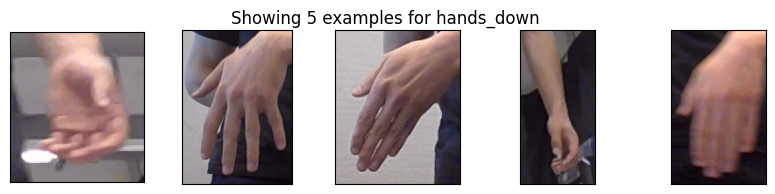

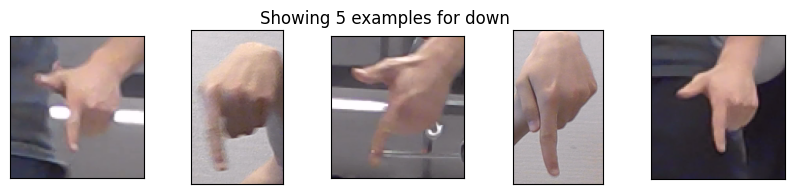

In [5]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()


In [6]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)


Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_249.png


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_485.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_485.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_402.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_402.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_406.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_406.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_458.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_458.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_367.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_367.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_410.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_410.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_367.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_367.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_495.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_495.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_533.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_533.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_407.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_407.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_534.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_534.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_412.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_412.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_422.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_422.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_450.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_450.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_519.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_519.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_439.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_439.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_460.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_460.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_370.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_370.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_543.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_543.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_382.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_382.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_399.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_399.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_491.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_491.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_413.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_413.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_429.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_429.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_426.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_426.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_481.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_481.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_409.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_409.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_526.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_526.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_362.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_466.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_466.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_384.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_384.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_388.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_388.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_385.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_385.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_487.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_487.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_430.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_430.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_392.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_392.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_375.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_375.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_471.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_471.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_451.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_451.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_434.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_434.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_536.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_536.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_369.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_369.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_371.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_371.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_405.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_405.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_523.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_523.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_365.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_365.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_404.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_404.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_475.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_475.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_505.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_505.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_378.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_378.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_501.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_501.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_386.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_386.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_434.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_434.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_455.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_455.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_467.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_467.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_386.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_386.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_423.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_423.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_456.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_456.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_520.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_520.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_461.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_461.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_537.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_537.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_415.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_415.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_445.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_445.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_373.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_373.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_390.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_390.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_402.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_402.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_432.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_432.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_517.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_517.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_392.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_392.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_504.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_504.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_469.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_469.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_395.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_395.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_394.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_394.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_418.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_418.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_419.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_419.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_372.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_372.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_423.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_423.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_446.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_446.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_476.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_476.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_508.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_508.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_393.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_393.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_403.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_403.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_366.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_356.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_390.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_390.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_516.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_516.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_528.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_528.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_404.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_404.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_330.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_428.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_428.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_375.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_375.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_381.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_381.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_359.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_403.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_403.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_527.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_527.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_376.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_376.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_518.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_518.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_515.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_515.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_380.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_380.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_414.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_414.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_503.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_503.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_374.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_374.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_370.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_370.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_525.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_525.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_532.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_532.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_453.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_453.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_401.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_401.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_506.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_506.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_374.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_374.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_428.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_428.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_417.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_417.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_530.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_530.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_408.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_408.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_480.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_480.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_383.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_383.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_529.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_529.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_324.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_397.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_397.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_448.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_448.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_463.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_463.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_388.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_388.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_470.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_470.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_507.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_507.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_381.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_381.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_347.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_377.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_377.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_438.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_438.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_500.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_500.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_340.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_389.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_389.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_420.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_420.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_432.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_432.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_509.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_509.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_412.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_412.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_494.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_494.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_334.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_496.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_496.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_459.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_459.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_376.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_376.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_408.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_408.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_409.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_409.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_411.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_411.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_545.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_545.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_395.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_395.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_465.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_465.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_436.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_436.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_538.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_538.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_429.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_429.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_401.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_401.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_477.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_477.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_452.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_452.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_377.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_377.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_414.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_414.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_468.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_468.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_400.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_400.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_535.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_535.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_406.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_406.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_327.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_348.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_415.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_415.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_524.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_524.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_431.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_431.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_433.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_433.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_358.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_473.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_473.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_407.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_407.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_427.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_427.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_322.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_345.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_464.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_464.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_391.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_391.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_510.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_510.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_449.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_449.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_331.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_443.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_443.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_489.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_489.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_387.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_387.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_391.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_391.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_357.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_332.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_319.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_400.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_400.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_447.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_447.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_320.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_393.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_393.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_483.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_483.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_514.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_514.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_424.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_424.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_398.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_398.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_389.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_389.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_329.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_482.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_482.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_373.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_373.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_333.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_338.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_472.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_472.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_387.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_387.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_325.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_335.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_426.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_426.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_328.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_372.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_372.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_383.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_383.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_444.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_444.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_410.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_410.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_399.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_399.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_511.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_511.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_541.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_541.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_478.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_478.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_490.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_490.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_396.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_396.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_323.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_360.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_369.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_369.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_502.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_502.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_531.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_531.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_474.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_474.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_398.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_398.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_435.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_435.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_479.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_479.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_416.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_416.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_499.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_499.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_349.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_343.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_378.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_378.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_513.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_513.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_411.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_411.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_425.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_425.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_457.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_457.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_431.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_431.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_419.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_419.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_336.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_522.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_522.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_427.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_427.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_497.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_497.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_368.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_368.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_379.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_379.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_380.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_380.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_384.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_384.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_416.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_416.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_321.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_440.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_440.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_417.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_417.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_454.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_454.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_433.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_433.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_421.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_421.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_512.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_512.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_364.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_441.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_441.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_540.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_540.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_437.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_437.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_342.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_394.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_394.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_368.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_368.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_430.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_430.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_361.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_492.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_492.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_521.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_521.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_339.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_486.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_486.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_424.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_424.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_371.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_371.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_413.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_413.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_355.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_337.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_354.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_546.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_546.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_442.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_442.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_493.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_493.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_344.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_396.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_396.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_462.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_462.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_418.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_418.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_341.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_422.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_422.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_539.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_539.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_385.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_385.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_488.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_488.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_353.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_352.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_365.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_365.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_397.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_397.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_363.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_421.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_421.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_382.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_382.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_484.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_484.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_498.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_498.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_351.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_435.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_435.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_542.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_542.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_425.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_425.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_544.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_544.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_405.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_405.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_420.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_420.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_326.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/2_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_346.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_350.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/2_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/2_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_379.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_379.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/2_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/2_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_365.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/2_365.png
2023-06-08 08:21:06.584745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-08 08:21:06.584792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: guillaume-Yoga
2023-06-08 08:21:06.584798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: guillaume-Yoga
2023-06-08 08:21:06.584968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-06-08 08:21:06.584984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.182.3
2023-06-08 08:21:06.584989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.182.

Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Load valid hands with size: 3310, num_label: 6, labels: none,come,down,hands_down,sit,stay.


INFO:tensorflow:Load valid hands with size: 3310, num_label: 6, labels: none,come,down,hands_down,sit,stay.


In [7]:
hparams = gesture_recognizer.HParams(export_dir="exported_model_test")
hparams.epochs = 15
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer)  [(None, 128)]            0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_o  (None, 6)                774       
 ut (Dense)                                                      
                                                                 
Total params: 1,286
Trainable params: 1,030
Non-trainable par

INFO:tensorflow:Training the models...


Resuming from exported_model_test/epoch_models/model-0015
Epoch 1/15
1324/1324 [==============================] - 3s 2ms/step - loss: 0.6379 - categorical_accuracy: 0.6261 - val_loss: 0.2683 - val_categorical_accuracy: 0.7885 - lr: 0.0010
Epoch 2/15
1324/1324 [==============================] - 2s 1ms/step - loss: 0.5867 - categorical_accuracy: 0.6567 - val_loss: 0.2469 - val_categorical_accuracy: 0.8006 - lr: 9.9000e-04
Epoch 3/15
1324/1324 [==============================] - 2s 1ms/step - loss: 0.5682 - categorical_accuracy: 0.6684 - val_loss: 0.2398 - val_categorical_accuracy: 0.8127 - lr: 9.8010e-04
Epoch 4/15
1324/1324 [==============================] - 2s 1ms/step - loss: 0.5507 - categorical_accuracy: 0.6779 - val_loss: 0.2357 - val_categorical_accuracy: 0.8127 - lr: 9.7030e-04
Epoch 5/15
1324/1324 [==============================] - 2s 1ms/step - loss: 0.5474 - categorical_accuracy: 0.6767 - val_loss: 0.2414 - val_categorical_accuracy: 0.8097 - lr: 9.6060e-04
Epoch 6/15
1324/1324 

In [8]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")


331/331 [==============================] - 1s 837us/step - loss: 0.2504 - categorical_accuracy: 0.8218
Test loss:0.2504301965236664, Test accuracy:0.8217522501945496


In [13]:
dir(test_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dataset',
 '_label_names',
 '_size',
 '_split',
 'from_folder',
 'gen_tf_dataset',
 'label_names',
 'num_classes',
 'size',
 'split']

In [17]:
model.export_model()
!ls exported_model


Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/canned_gesture_classifier.tflite
INFO:tensorflow:Assets written to: /tmp/tmp0bs0mz60/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bs0mz60/saved_model/assets
2023-06-06 18:53:50.148422: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-06 18:53:50.148446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


best_model_weights.data-00000-of-00001	epoch_models		 metadata.json
best_model_weights.index		gesture_recognizer.task
checkpoint				logs


2023-06-06 18:53:50.148551: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0bs0mz60/saved_model
2023-06-06 18:53:50.149299: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-06 18:53:50.149312: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0bs0mz60/saved_model
2023-06-06 18:53:50.151130: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-06-06 18:53:50.165293: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0bs0mz60/saved_model
2023-06-06 18:53:50.169742: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 21190 microseconds.


## visual tests using webcam

In [3]:
recognizer = vision.GestureRecognizer.create_from_model_path("exported_model_4/gesture_recognizer.task")

W20230608 08:40:55.721809 62818 gesture_recognizer_graph.cc:128] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [15]:
import os
import cv2
import numpy as np
import random

# Set the path to your test folder
test_folder = 'hands_test'

# Set the number of images per class
images_per_class = 20

# Initialize lists for images and true labels
images = []
true_labels = []
predicted_labels = []

# Load your MediaPipe model
# Replace 'your_model_path' with the actual path to your model
model = recognizer

# Iterate through the test folder
for folder_name in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder_name)
    if os.path.isdir(folder_path):
        # Get a list of image file names in the current class folder
        image_files = [os.path.join(folder_path, image_name) for image_name in os.listdir(folder_path)]
        
        # Randomly select 10 images from the current class folder
        random_images = random.sample(image_files, images_per_class)
        
        # Process the randomly selected images
        for image_file_name in random_images:
            # Load the input image
            image = mp.Image.create_from_file(image_file_name)

            # Recognize gestures in the input image
            recognition_result = model.recognize(image)

            # Process the result. In this case, visualize it.
            images.append(image)
            try:
                top_gesture = recognition_result.gestures[0][0]
                predicted_labels.append(top_gesture.category_name)
                true_label = folder_name
                true_labels.append(true_label)
            except:
                pass
            

            # Extract the true label from the image file name
            

print(f"true labels = {true_labels}")
print(f"predicted labels = {predicted_labels}")



true labels = ['stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'stay', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'come', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'sit', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'hands_down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down', 'down']
predicted labels = ['stay', 'stay', 'stay', 'stay'

In [16]:
from sklearn.preprocessing import LabelEncoder

# Combine the predicted labels and true labels
all_labels_text = predicted_labels + true_labels

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on all labels to obtain label-to-ID mapping
le.fit(all_labels_text)

# Convert predicted labels and true labels to numeric indices
predicted_labels_numeric = le.transform(predicted_labels)
true_labels_numeric = le.transform(true_labels)

# Create a label-to-ID mapping
label2id = {label: id for label, id in zip(le.classes_, le.transform(le.classes_))}

# Print the numeric labels and label-to-ID mapping
print("Predicted Labels (numeric):", predicted_labels_numeric)
print("True Labels (numeric):", true_labels_numeric)
print("Label-to-ID Mapping:", label2id)

Predicted Labels (numeric): [6 6 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 1 3 1 1 1 1 1 1 1 1 1 1 4 4 6 4 4 0
 4 4 2 4 4 4 4 4 4 4 4 4 4 4 5 5 5 6 5 5 5 5 5 5 5 4 5 5 5 5 5 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 2 2 2 2 2 3 0 2 2 0 3 2 2 3]
True Labels (numeric): [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Label-to-ID Mapping: {'': 0, 'come': 1, 'down': 2, 'hands_down': 3, 'none': 4, 'sit': 5, 'stay': 6}


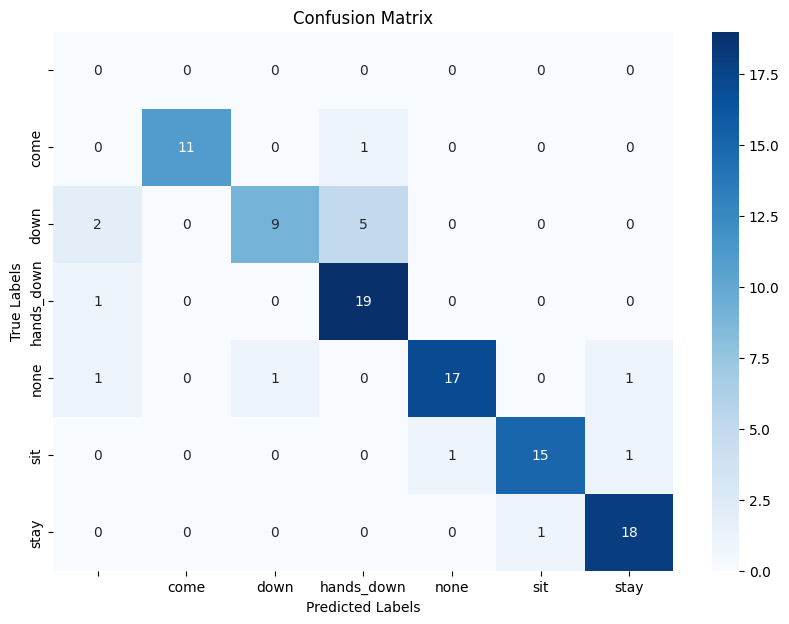

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


plot_confusion_matrix(true_labels_numeric, predicted_labels_numeric, label2id.keys())

In [21]:
recognition_result

GestureRecognizerResult(gestures=[], handedness=[], hand_landmarks=[], hand_world_landmarks=[])

### Hands only

In [ ]:
new_frame_time = 0
prev_frame_time = 0

# Open the webcam
cap = cv2.VideoCapture(0)  # 0 represents the default webcam, change it if necessary

# Check if the webcam is successfully opened
if not cap.isOpened():
    print("Unable to open the webcam.")

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    
    # Check if the frame is successfully read
    if not ret:
        print("Failed to read the frame.")
        break

    frame = cv2.flip(frame,1)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
    result = recognizer.recognize_async(mp_image) #hands detection and classification

    try:
        prediction = result.gestures[0][0].category_name
        confidence = result.gestures[0][0].score  
        hand_landmarks = result.hand_world_landmarks
        
        if prediction == None:
            prediction = "None"
    
    except:
        prediction = "no hands"
        confidence = ""

    annotated_image = draw_landmarks_on_image(frame, result)

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

### Hands and body keypoints

In [ ]:
new_frame_time = 0
prev_frame_time = 0

# Open the webcam
cap = cv2.VideoCapture(0)  # 0 represents the default webcam, change it if necessary

# Check if the webcam is successfully opened
if not cap.isOpened():
    print("Unable to open the webcam.")

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    
with mp_pose.Pose(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()
        # Check if the frame is successfully read
        if not ret:
            print("Failed to read the frame.")
            break

        frame = cv2.flip(frame,1)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
        result = recognizer.recognize(mp_image) #hands detection and classification
        pose_results = pose.process(frame) # find body keypoints

        try:
            prediction = result.gestures[0][0].category_name
            confidence = result.gestures[0][0].score  
            hand_landmarks = result.hand_world_landmarks
            
            if prediction == None:
                prediction = "None"
        
        except:
            prediction = "no hands"
            confidence = ""

        annotated_image = draw_landmarks_on_image(frame, result)

        mp_drawing.draw_landmarks(
        annotated_image,
        pose_results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # Write the prediction text on the frame
        cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display the frame in a window named 'Webcam Feed'
        cv2.imshow('Webcam Feed', annotated_image)
        
        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
            break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

## Using realsense

### start the pipeline

In [ ]:
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)

device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))
found_rgb = False

for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)



if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 1280, 800, rs.format.bgr8, 30)



### Using livestream model


In [ ]:
pipeline.stop()
cv2.destroyAllWindows()

In [ ]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
GestureRecognizerResult = mp.tasks.vision.GestureRecognizerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the live stream mode:
def print_result(result: GestureRecognizerResult, output_image: mp.Image, timestamp_ms: int, global_result):
    print('gesture recognition result: {}'.format(result))
    glob_result = result

# crashes the kernel if used ....
# def display_results(result: GestureRecognizer, output_image: mp.Image, timestamp_ms: int, global_result):
    
#     prediction = glob_result.gestures[0][0].category_name
#     confidence = glob_result.gestures[0][0].score  
#     annotated_image = draw_landmarks_on_image(output_image.numpy_view(), result)
#     cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
#     # Display the frame in a window named 'Webcam Feed'
#     cv2.imshow('Webcam Feed', annotated_image)


options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

global glob_result
glob_result = None

with GestureRecognizer.create_from_options(options) as recognizer:
    pipeline.start(config)

    new_frame_time = 0
    prev_frame_time = 0

    cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
        
    while True:

        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()

        timestamp = color_frame.get_timestamp()
        print(timestamp)
        
        if not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())

        frame = cv2.flip(color_image,1)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
        recognizer.recognize_async(mp_image, int(timestamp)) #hands detection and classification

        try:
            prediction = glob_result.gestures[0][0].category_name
            confidence = glob_result.gestures[0][0].score  

            annotated_image = draw_landmarks_on_image(frame, result)
            
            if prediction == None:
                prediction = "None"
        
        except:
            prediction = "no hands"
            confidence = ""
            annotated_image = frame

    
        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # Write the prediction text on the frame
        cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display the frame in a window named 'Webcam Feed'
        cv2.imshow('Webcam Feed', annotated_image)
        
        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
            break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()
    

### Hands only

In [ ]:
import time

In [ ]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    
while True:

    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    
    if not color_frame:
        continue

    color_image = np.asanyarray(color_frame.get_data())

    frame = cv2.flip(color_image,1)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
    result = recognizer.recognize_async(mp_image, time.time()) #hands detection and classification

    try:
        prediction = result.gestures[0][0].category_name
        confidence = result.gestures[0][0].score  
        hand_landmarks = result.hand_world_landmarks
        
        if prediction == None:
            prediction = "None"
    
    except:
        prediction = "no hands"
        confidence = ""

    annotated_image = draw_landmarks_on_image(frame, result)

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

### Hands and body

In [ ]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the image mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE,
    num_hands = 1,
    min_hand_detection_confidence=0.1,
    min_hand_presence_confidence=0.1)
with GestureRecognizer.create_from_options(options) as recognizer:
    with mp_pose.Pose(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:    
        while True:

            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            
            if not color_frame:
                continue

            color_image = np.asanyarray(color_frame.get_data())

            frame = cv2.flip(color_image,1)

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
            result = recognizer.recognize(mp_image) #hands detection and classification
            pose_results = pose.process(frame) # find body keypoints

            # print(f"hand results {result}")


            try:
                prediction = result.gestures[0][0].category_name
                confidence = result.gestures[0][0].score  
                hand_landmarks = result.hand_world_landmarks
                
                if prediction == None:
                    prediction = "None"
            
            except:
                prediction = "no hands"
                confidence = ""

            annotated_image = draw_landmarks_on_image(frame, result)

            mp_drawing.draw_landmarks(
            annotated_image,
            pose_results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time

            # Write the prediction text on the frame
            print(prediction)
            cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display the frame in a window named 'Webcam Feed'
            cv2.imshow('Webcam Feed', annotated_image)
            
            # Exit the loop if the 'q' key is pressed
            if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
                break

    # Release the webcam and close the window
    pipeline.stop()
    cv2.destroyAllWindows()

### Hands and body with hand recrop

In [ ]:
def get_hand_coordinates(pose_landmarks):
    left_hand_coords = {"max_x": -1000, "max_y": -1000, "min_x": 1000, "min_y": 1000}
    right_hand_coords = {"max_x": -1000, "max_y": -1000, "min_x": 1000, "min_y": 1000}

    left_hand_index = [17, 19, 21] # wrist pinky index thumb
    right_hand_index = [18, 20, 22]

    margin = 0

    # Extract the coordinates of the left and right hands
    for idx, landmark in enumerate(pose_landmarks.landmark):
        if idx in left_hand_index:
              # Left hand
            if landmark.x > left_hand_coords["max_x"]:
                left_hand_coords["max_x"] = landmark.x
            if landmark.y > left_hand_coords["max_y"]:
                left_hand_coords["max_y"] = landmark.y
            if landmark.x < left_hand_coords["min_x"]:
                left_hand_coords["min_x"] = landmark.x
            if landmark.y < left_hand_coords["min_y"]:
                left_hand_coords["min_y"] = landmark.y

        elif idx in right_hand_index:  # Right hand

            if landmark.x > right_hand_coords["max_x"]:
                right_hand_coords["max_x"] = landmark.x
            if landmark.y > right_hand_coords["max_y"]:
                right_hand_coords["max_y"] = landmark.y
            if landmark.x < right_hand_coords["min_x"]:
                right_hand_coords["min_x"] = landmark.x
            if landmark.y < right_hand_coords["min_y"]:
                right_hand_coords["min_y"] = landmark.y


    if any(item < 0 or item > 1 for item in left_hand_coords.values()): # coordinates are out of the frame
        left_hand_coords = None
    if any(item <0 or item > 1 for item in right_hand_coords.values()):
        right_hand_coords = None

    return right_hand_coords, left_hand_coords # we have to switch them here due to the cv2.flip

def crop_hand(frame, hand_coords):
    # image_height, image_width = frame.height, frame.width
    
    image_height, image_width, _ = frame.shape

    margin = 80

    x_min = max(0, int(hand_coords["min_x"] * image_width) - margin)
    y_min = max(0, int(hand_coords["min_y"] * image_height) - margin)
    x_max = min(image_width - 1, int(hand_coords["max_x"] * image_width) + margin)
    y_max = min(image_height - 1, int(hand_coords["max_y"] * image_height) + margin)

    # Crop the image around the hand region
    hand_image = frame[y_min:y_max, x_min:x_max]

    return hand_image

In [ ]:
def classify_hand(mp_image):

        # mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = hand_image)
        # mp_image = hand_image
        result = recognizer.recognize(mp_image) 
    
        try:
            prediction = result.gestures[0][0].category_name
            confidence = result.gestures[0][0].score          
        except:
            prediction = "no hands hee"
            confidence = ""

        return prediction, confidence

In [ ]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the image mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE,
    num_hands = 1,
    min_hand_detection_confidence=0.2,
    min_hand_presence_confidence=0.2)
with GestureRecognizer.create_from_options(options) as recognizer:


    with mp_pose.Pose(
        model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:    
        while True:

            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            
            if not color_frame:
                continue

            color_image = np.asarray(color_frame.get_data())
            frame = cv2.flip(color_image,1)

            #hands detection and classification
            pose_results = pose.process(frame) # find body keypoints

            right_pred = "no hands"
            right_conf = ""

            if pose_results.pose_landmarks:
                # Get the coordinates of the left and right hands
                _, right_hand_coords = get_hand_coordinates(pose_results.pose_landmarks)
                
                if right_hand_coords is not None:
                    right_hand_image = (crop_hand(frame, right_hand_coords))
                    # right_hand_image = cv2.flip(right_hand_image,1)
                    # right_hand_image = cv2.flip(right_hand_image,1)
                    right_hand_image = cv2.cvtColor(right_hand_image, cv2.COLOR_BGR2RGB)
                    right_hand_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = right_hand_image)
                    right_pred, right_conf = classify_hand(right_hand_image)
                    

                    # Draw the bounding box and prediction on the frame
                    margin_x = 80
                    margin_y = int(margin_x * 1.25)
                    image_height, image_width, _ = frame.shape
                    x_min = max(0, int(right_hand_coords["min_x"] * image_width) - margin_x)
                    y_min = max(0, int(right_hand_coords["min_y"] * image_height) - margin_y)
                    x_max = min(image_width - 1, int(right_hand_coords["max_x"] * image_width) + margin_x)
                    y_max = min(image_height - 1, int(right_hand_coords["max_y"] * image_height) + margin_y)
                    start_box = (x_min, y_min)
                    end_box = (x_max, y_max)
                    frame = cv2.rectangle(frame, start_box, end_box, (255,0,0), 2)
                    cv2.putText(frame, right_pred, start_box, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)



            # annotated_image = draw_landmarks_on_image(frame, result)
            annotated_image = frame

            mp_drawing.draw_landmarks(
            annotated_image,
            pose_results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time

            # Write the prediction text on the frame
            # cv2.putText(annotated_image, f"Left hand: {left_pred} ({left_conf})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # cv2.putText(annotated_image, f"Right hand: {right_pred} ({right_conf})", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display the frame in a window named 'Webcam Feed'
            cv2.imshow('Webcam Feed', annotated_image)
            
            # Exit the loop if the 'q' key is pressed
            if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
                break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

In [ ]:
color_frame

In [ ]:
pipeline.stop()
cv2.destroyAllWindows()

### Openpifpaf and hand

In [ ]:
import openpifpaf
import torch
import PIL
import numpy as np
import cv2
import time
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances

In [ ]:
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoulder": 5,
        "right_shoulder": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}

link_dict = {
        "nose": [("nose", "left_eye"),("nose", "right_eye")],
        "left_eye": [("left_eye", "left_ear")],
        "right_eye": [("right_eye", "right_ear")],
        "left_shoulder": [("left_shoulder", "left_elbow"),("left_shoulder", "left_hip"),("left_shoulder", "right_shoulder")],
        "right_shoulder": [("right_shoulder", "right_elbow"),("right_shoulder", "right_hip")],
        "left_elbow": [("left_elbow", "left_wrist")],
        "right_elbow": [("right_elbow", "right_wrist")],
        "left_hip": [("left_hip", "left_knee"),("left_hip", "right_hip")],
        "right_hip": [("right_hip", "right_knee")],
        "left_knee": [("left_knee", "left_ankle")],
        "right_knee": [("right_knee", "right_ankle")]}




In [ ]:
def display_whole_skeleton(keypoints, frame, pos_dict = pos_dict, link_dict = link_dict):
    for key in pos_dict:
        try:
            keypoint = keypoints[pos_dict[key],0:2]
            cv2.circle(frame, tuple(map(int, tuple(keypoint))), 5, RED, -1)
            try:
                links = link_dict[key]
                if len(links) > 1:
                    for link in links:
                            keypoint1 = keypoints[pos_dict[link[0]],0:2]
                            keypoint2 = keypoints[pos_dict[link[1]],0:2]
                            # if keypoint1 == [0.0,0.0] or keypoint2 == [0.0,0.0]:
                            #     continue
                            cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
                else:
                    keypoint1 = keypoints[pos_dict[links[0][0]],0:2]
                    keypoint2 = keypoints[pos_dict[links[0][1]],0:2]
                    # if keypoint1 == [0.0,0.0]or keypoint2 == [0.0,0.0]:
                    #     continue
                    cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
            except:
                continue
        except:
            continue

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

In [ ]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)


while True:

    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    
    if not color_frame:
        continue

    color_image = np.asarray(color_frame.get_data())
    pil_img = PIL.Image.fromarray(color_image)
    predictions, _, _ = predictor.pil_image(pil_img)
    # mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame

    # display_whole_skeleton(predictions[0].data, color_image)

    annotated_image = color_image

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    # cv2.putText(annotated_image, f"Left hand: {left_pred} ({left_conf})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(annotated_image, f"Right hand: {right_pred} ({right_conf})", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

In [ ]:
pipeline.stop()
cv2.destroyAllWindows()